![Компьютер говорит "Нет"](https://media1.tenor.com/images/2ff04b32395b3958d9c2fb6ea3f7b957/tenor.gif?itemid=12232216)
## Проект 4. Компьютер говорит «Нет»

**Цель проекта**

Создать модель банковского скоринга, которая позволит спрогнозировать вероятность невозврата кредита.

Причём модель должна успешно справляться как с ошибкой первого рода (отказ в кредите хорошему заёмщику), так и второго (выдача кредита неблагонадёжному заёмщику) рода.

Будем предсказывать кредитный скоринг в интервале от 0 до 1, абстрагируясь от порогового значения, при котором банк будет выдавать / отказывать в выдаче кредита (каждый банк может установить этот порог по-своему).

#### Признаки датасета
* client_id - идентификатор клиента
* education - уровень образования
* sex - пол заемщика
* age - возраст заемщика
* car - флаг наличия автомобиля
* car_type - флаг автомобиля иномарки
* decline_app_cnt - количество отказанных прошлых заявок
* good_work - флаг наличия “хорошей” работы
* bki_request_cnt - количество запросов в БКИ
* home_address - категоризатор домашнего адреса
* work_address - категоризатор рабочего адреса
* income - доход заемщика
* foreign_passport - наличие загранпаспорта
* sna - связь заемщика с клиентами банка
* first_time - давность наличия информации о заемщике
* score_bki - скоринговый балл по данным из БКИ
* region_rating - рейтинг региона
* app_date - дата подачи заявки
* <span style="color:red">default</span> - флаг дефолта по кредиту

**Целевая переменная**: default

---

### 1. Загрузка библиотек и файлов данных

In [1]:
import pandas as pd
import numpy as np
import os

from math import ceil

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import auc, roc_auc_score, roc_curve

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 100) # показывать больше колонок

In [2]:
RANDOM_SEED = 42

!pip freeze > requirements.txt

In [3]:
PATH_TO_FILE = './kaggle/input/'

train = pd.read_csv(PATH_TO_FILE + 'train.csv')

test = pd.read_csv(PATH_TO_FILE + 'test.csv')

---

### 2. Первичный анализ данных

In [4]:
# В каждом датасете инициализируем признак типа датасета:
#   1 = тренировочные данные
#   0 = проверочные данные

train['Training'] = 1

test['Training'] = 0

In [5]:
# Объединим датасет в один общий

df = train.append(test, sort=False).reset_index(drop=True) 

In [6]:
# Анализируем признаки, пропуски и типы данных

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [7]:
f"Кол-во тренировочных записей: {len(df[df['Training'] == 1])};\
  Кол-во проверочных записей: {len(df[df['Training'] == 0])}"

'Кол-во тренировочных записей: 73799;  Кол-во проверочных записей: 36349'

In [8]:
# Смотрим на выборку записей

df.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,Training
39165,57159,05MAR2014,SCH,F,32,N,N,1,0,-1.590340,2,50,2,3,20000,1,1,N,0.0,1
34516,44338,20FEB2014,UGR,F,55,N,N,0,0,-2.467284,2,40,2,3,13200,1,3,N,0.0,1
9619,85466,02APR2014,SCH,F,41,N,N,0,0,-1.276923,2,40,2,3,15000,1,4,Y,0.0,1
82174,98814,15APR2014,SCH,F,51,N,N,0,0,-2.148140,1,60,1,2,15000,1,3,N,NaN,0
102442,60550,10MAR2014,GRD,F,58,N,N,0,1,-1.347651,6,60,1,2,50000,2,4,Y,NaN,0


In [9]:
# Для численных признаков смотрим описательные статистики

df.describe().round(2)

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default,Training
count,110148.00,110148.00,110148.00,110148.00,110148.00,110148.00,110148.00,110148.00,110148.00,110148.00,110148.00,110148.00,73799.00,110148.00
mean,55074.50,39.25,0.27,0.17,-1.90,2.01,56.75,1.57,2.50,41012.65,1.73,2.77,0.13,0.67
std,31797.13,11.52,0.80,0.37,0.50,2.27,13.07,0.53,0.69,45399.74,1.12,1.01,0.33,0.47
min,1.00,21.00,0.00,0.00,-3.62,0.00,20.00,1.00,1.00,1000.00,1.00,1.00,0.00,0.00
25%,27537.75,30.00,0.00,0.00,-2.26,0.00,50.00,1.00,2.00,20000.00,1.00,2.00,0.00,0.00
50%,55074.50,37.00,0.00,0.00,-1.92,1.00,50.00,2.00,3.00,30000.00,1.00,3.00,0.00,1.00
75%,82611.25,48.00,0.00,0.00,-1.57,3.00,60.00,2.00,3.00,48000.00,2.00,4.00,0.00,1.00
max,110148.00,72.00,33.00,1.00,0.20,53.00,80.00,3.00,3.00,1000000.00,4.00,4.00,1.00,1.00


In [10]:
# Пропуски по столбцам

df[df['Training'] == 1].isnull().sum()

client_id             0
app_date              0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
Training              0
dtype: int64

In [11]:
# Повторяющиеся записи (целиком)

df.duplicated().sum()

0

In [12]:
# Повторяющиеся записи клиентов (с другими данными)

df['client_id'].duplicated().sum()

0

**Вывод**

* 19 признаков (+1 дополненный для отличия типа датасета):
    * 13 - числовые
    * 6 - строковые
* Датасет разделен на:
    * 73799 - тренировочных строк
    * 36349 - проверочных
* Пропуски есть только в столбце 'education'
* Нет повторяющихся значений
* Каждая строка представляет собой уникальную и суммарную запись клиента (т.е. отсутствует несколько записей клиента для подсчёта метрик каждого клиента, скажем, во времени)
* Целевая переменная, которую будем предсказывать - 'default'

---

### 3. Анализ и предобработка признаков

#### client_id

In [13]:
# Смотрим описательные статистики признака client_id

df['client_id'].describe().round(2)

count    110148.00
mean      55074.50
std       31797.13
min           1.00
25%       27537.75
50%       55074.50
75%       82611.25
max      110148.00
Name: client_id, dtype: float64

In [14]:
f"Количество уникальных значение признака client_id: {df['client_id'].nunique()}"

'Количество уникальных значение признака client_id: 110148'

**Вывод**

client_id, как и предполагает название, является уникальным идентификатором клиента. Можно использовать в качестве индекса, но для анализа бесполезен.

#### app_date

In [15]:
# Частотный анализ переменной app_date

df['app_date'].value_counts()

18MAR2014    1491
19MAR2014    1363
17MAR2014    1350
31MAR2014    1317
07APR2014    1296
             ... 
20APR2014     359
07JAN2014     349
03JAN2014     313
02JAN2014     204
01JAN2014      56
Name: app_date, Length: 120, dtype: int64

In [16]:
# Поменяем формат на datetime и рассчитаем признак с кол-вом дней с начала отсчёта (app_date_inc)

df['app_date'] = pd.to_datetime(df['app_date'], format='%d%b%Y')

df['app_date_days'] = (df['app_date'] - df['app_date'].min()).dt.days

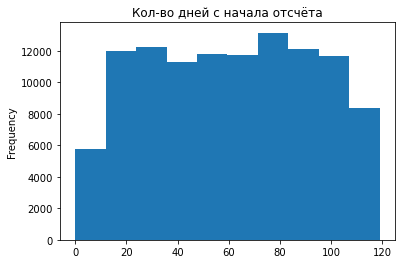

In [17]:
# Чертим график распределения записей к кол-ву дней с момента отсчёта

df['app_date_days'].plot(kind='hist', title='Кол-во дней с начала отсчёта')

In [18]:
# Добавим параметр месяца подачи заявки

df['app_date_month'] = df['app_date'].dt.month

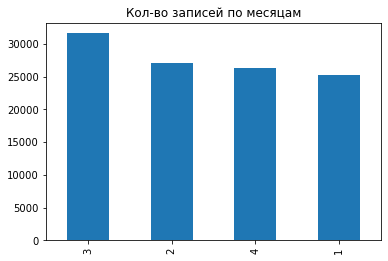

In [19]:
# Чертим график распределения месяцев

df['app_date_month'].value_counts().plot(kind='bar', title='Кол-во записей по месяцам')

**Вывод**

app_date перевели в формат даты и обогатили датасет доп. признаками - кол-вом дней после начала отсчёта и месяцем подачи заявки.
Кол-во заявок по дням с начала отсчёта - нормально распределение, б*о*льшая часть заявок была подана между 20 и 100 днём, что соответствует марту и февралю (1 и 2 место соответственно).

#### education

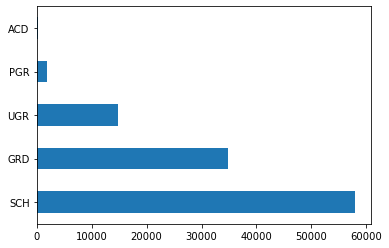

In [20]:
# Рисуем график распределения значений признака education

df['education'].value_counts().plot.barh()

In [21]:
f"Кол-во пропусков в признаке 'education': {df['education'].isnull().sum()}"

"Кол-во пропусков в признаке 'education': 478"

In [22]:
# Заполняем пропуски в образовании на основании вероятностей заполненных значений

edu_probability = list(pd.Series(df['education'].value_counts(normalize=True).round(2)))
edu_values = list(pd.Series(df['education'].value_counts().index))


def fill_education():
    return np.random.choice(edu_values, p=edu_probability)


df['education'].fillna(fill_education(), inplace=True)

In [23]:
# Кодируем категориальное значение параметра education в целочисленные эквиваленты

ed_dict = dict(enumerate(pd.Series(df['education'].unique())))
ed_dict2 = {v : k for k, v in ed_dict.items()}
display(ed_dict2)

df['education'] = df['education'].replace(ed_dict2)

df['education'].value_counts(normalize=True).round(2)

{'SCH': 0, 'GRD': 1, 'UGR': 2, 'PGR': 3, 'ACD': 4}

0    0.53
1    0.32
2    0.13
3    0.02
4    0.00
Name: education, dtype: float64

**Вывод**

Обнаруженные пропуски заполнены вероятностными значениями + параметр перекодирован в целочисленные
значения.

Самая частая категория SCH (53%) - оконченное школьное (?).

#### sex

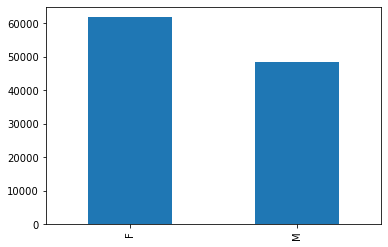

In [24]:
# Рисуем график распределения значений признака sex

df['sex'].value_counts().plot.bar()

In [25]:
# Смотрим удельные значения полов

df['sex'].value_counts(normalize=True).round(2)

F    0.56
M    0.44
Name: sex, dtype: float64

In [26]:
# Перекодируем значения данного признака в целочисленные

sex_dict = {'M' : 0
           ,'F' : 1}

df['sex'] = df['sex'].replace(sex_dict)

**Вывод**

В датасете больше заявок от женщин (56%).

Признак конвертирован в целочисленный.

#### age

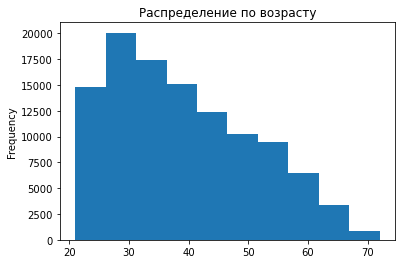

In [27]:
# Чертим график распределения признака age

df['age'].plot(kind='hist', title='Распределение по возрасту')

In [28]:
# Смотрим описательные статистики

df['age'].describe().round(0)

count    110148.0
mean         39.0
std          12.0
min          21.0
25%          30.0
50%          37.0
75%          48.0
max          72.0
Name: age, dtype: float64

**Вывод**

Средний возраст заявителя - 39 лет со стандартным отклонением 12. Подавляющая часть подающих заявки на займ (больше 75% квартиля) - до 50 лет.

#### car и car_type

Связанные переменные означающие наличие автомобиля, и конкретно наличие иномарки.

In [29]:
# Проверим эти параметры на наличие расхождений (иномарка = Y, машина = N)

f"Кол-во расхождений в параметрах машин: {len(df[(df['car'] == 'N') & (df['car_type'] == 'Y')])}"

# Проблемных записей не найдено

'Кол-во расхождений в параметрах машин: 0'

In [30]:
# Смотрим соотношения заявителей с машинами

display(f"Процент заявителей с машиной (к общему кол-ву заявителей): \
    {round(len(df[df['car_type'] == 'Y']) / len(df), 2)}")

display(f"Процент заявителей с иномаркой (к общему кол-ву заявителей с машиной): \
    {round(len(df[df['car_type'] == 'Y']) / len(df[df['car'] == 'Y']), 2)}")

'Процент заявителей с машиной (к общему кол-ву заявителей):     0.19'

'Процент заявителей с иномаркой (к общему кол-ву заявителей с машиной):     0.59'

(array([21008.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 89140.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

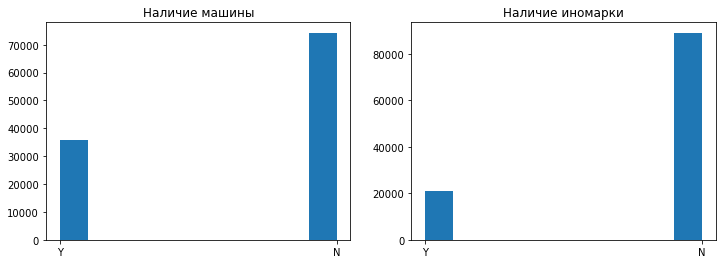

In [31]:
# Выведем графики обеих переменных

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].set_title('Наличие машины')
axes[0].hist(df['car'])

axes[1].set_title('Наличие иномарки')
axes[1].hist(df['car_type'])

In [32]:
# Определим словарь кодирования значений Y и N

yn_dict = {'Y' : 1
           ,'N' : 0}

In [33]:
# Кодируем значения обеих переменных на целочисленные

df[['car', 'car_type']] = df[['car', 'car_type']].replace(yn_dict)

**Вывод**

Только у 19% заявителей есть в наличии машина, но у б*о*льшей части из них это иномарка (59%).

Расхождений в значениях признаков не обнаружено.

Оба признака перекодированы в целочисленные эквиваленты.

#### decline_app_cnt

In [34]:
# Посмотрим распределение признака decline_app_cnt для десяти самых частых категорий и максимум

display(df['decline_app_cnt'].value_counts(normalize=True)[:10].round(3))

display(f"Максимальное кол-во отказов: {df['decline_app_cnt'].max()}")

0    0.830
1    0.113
2    0.033
3    0.012
4    0.006
5    0.002
6    0.001
7    0.001
8    0.000
9    0.000
Name: decline_app_cnt, dtype: float64

'Максимальное кол-во отказов: 33'

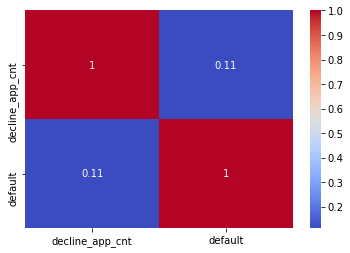

In [35]:
# Проверим есть ли корреляция между вероятностью невозврата и предыдущими отказами

sns.heatmap(df[['decline_app_cnt', 'default']][df['Training'] == 1].corr(), annot=True, cmap='coolwarm')

**Вывод**

У 83% заявителей не было до этого прошлых отказов. Из оставшихся 17% б*о*льшая часть получала от 1 до 3 отказов, хотя есть и такие случаи, когда до этого отказывали аж 33 раза.

Пародоксально, но кол-во предыдущих отказов слабо связано с риском невозврата, что скорее всего свидетельствует о слабой предсказательной силе моделей, на основании которых заявителям было отказано в прошлом.

#### good_work

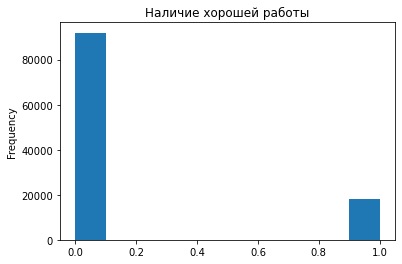

In [36]:
# Смотрим распределение признака good_work

df['good_work'].plot(kind='hist', title='Наличие хорошей работы')

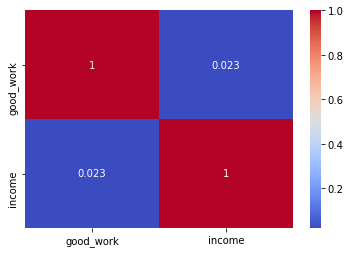

In [37]:
# Посмотрим есть ли корреляция между наличием хорошей работы и высокой зарплаты
# или же есть и другие факторы, которые отличают "хорошую" работы от "плохой"?

sns.heatmap(df[['good_work', 'income']][df['Training'] == 1].corr(), annot=True, cmap='coolwarm')

**Вывод**

Большинство заявителей не соответствуют критериям наличия "хорошей работы".

Вдвойне интересно, что наличие высокой зарплаты оч. слабо влияет на критерий "хорошести" работы.

#### score_bki

In [38]:
# Смотрим описательные статистики признака score_bki

df['score_bki'].describe().round(2)

count    110148.00
mean         -1.90
std           0.50
min          -3.62
25%          -2.26
50%          -1.92
75%          -1.57
max           0.20
Name: score_bki, dtype: float64

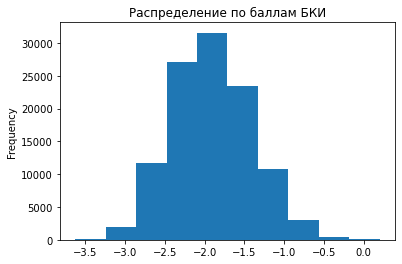

In [39]:
# Смотрим распределение признака score_bki

df['score_bki'].plot(kind='hist', title='Распределение по баллам БКИ')

**Вывод**

Распределение признака нормальное в рамках от -3,6 до +0,2 при среднем значении -1.9.

Рейтинг условный, поэтому будем дальше смотреть насколько он влияет на значение дефолта.

#### bki_request_cnt

In [40]:
# Смотрим описательные статистики признака bki_request_cnt

df['bki_request_cnt'].describe().round(2)

count    110148.00
mean          2.01
std           2.27
min           0.00
25%           0.00
50%           1.00
75%           3.00
max          53.00
Name: bki_request_cnt, dtype: float64

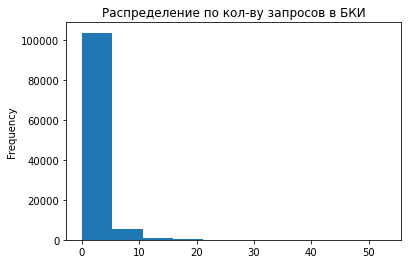

In [41]:
# Смотрим распределение признака bki_request_cnt

df['bki_request_cnt'].plot(kind='hist', title='Распределение по кол-ву запросов в БКИ')

**Вывод**

В среднем 1 запрос на клиента (медиана).

Распределение существенно смещенно влево.

#### region_rating

In [42]:
# Смотрим удельные значения рейтинга регионов

df['region_rating'].value_counts(normalize=True).round(2)

50    0.37
60    0.22
40    0.16
80    0.16
70    0.08
30    0.00
20    0.00
Name: region_rating, dtype: float64

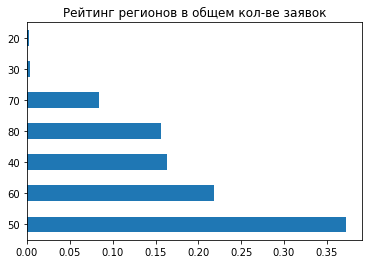

In [43]:
df['region_rating'].value_counts(normalize=True).plot(kind='barh', title='Рейтинг регионов в общем кол-ве заявок')

**Вывод**

Почти 60% заявок приходится на регионы с рейтингом 50 и 60.

#### home_address и work_address

Две переменные кодирующие категорию домашнего и рабочего адреса (описание категорий отсутствует) 

(array([48688.,     0.,     0.,     0.,     0., 59591.,     0.,     0.,
            0.,  1869.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <a list of 10 Patch objects>)

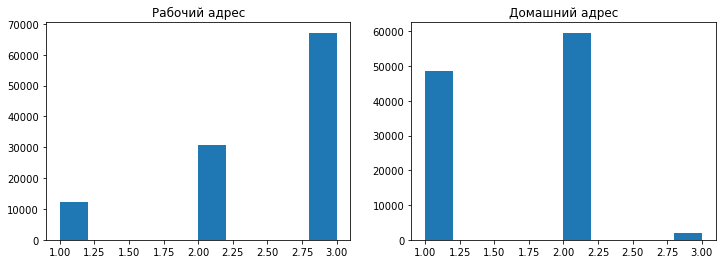

In [44]:
# Выведем графики обеих переменных

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].set_title('Рабочий адрес')
axes[0].hist(df['work_address'])

axes[1].set_title('Домашний адрес')
axes[1].hist(df['home_address'])

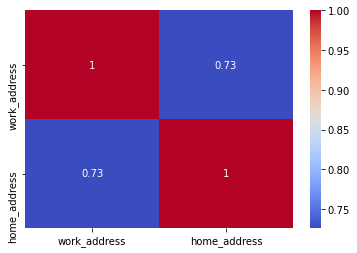

In [45]:
# Посмотрим есть ли взаимосвязь между адресами работы и домашним адресом

sns.heatmap(df[['work_address', 'home_address']].corr(), annot=True, cmap='coolwarm')

**Вывод**

Между категориями домашнего и рабочего адресов присутствует достаточно сильная взаимосвязь.

При этом распределение категорий рабочего адреса существенно смещено вправо, в то время как категории домашнего адреса "тяготеют" к низким значениям. 

#### income

In [46]:
# Смотрим описательные статистики переменной income

df['income'].describe().round(2)

count     110148.00
mean       41012.65
std        45399.74
min         1000.00
25%        20000.00
50%        30000.00
75%        48000.00
max      1000000.00
Name: income, dtype: float64

In [47]:
# Максимальное значение достаточно сильно разнится от 75% квартиля, посмотрим на наличие выбросов

df.groupby(by='Training')['income'].value_counts(bins=10)

Training                       
0         (0.999, 100900.0]        34825
          (100900.0, 200800.0]      1184
          (200800.0, 300700.0]       211
          (300700.0, 400600.0]        65
          (400600.0, 500500.0]        32
          (500500.0, 600400.0]        11
          (700300.0, 800200.0]         7
          (800200.0, 900100.0]         5
          (600400.0, 700300.0]         5
          (900100.0, 1000000.0]        4
1         (0.999, 100900.0]        70663
          (100900.0, 200800.0]      2423
          (200800.0, 300700.0]       445
          (300700.0, 400600.0]       106
          (400600.0, 500500.0]        74
          (500500.0, 600400.0]        32
          (900100.0, 1000000.0]       21
          (600400.0, 700300.0]        17
          (700300.0, 800200.0]        10
          (800200.0, 900100.0]         8
Name: income, dtype: int64

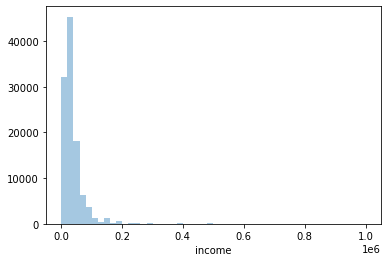

In [48]:
# Посмотрим на график распределения доходов

sns.distplot(df['income'], kde=False, rug=False)

**Вывод**

Медианный доход - 30 тыс., с достаточно большим разбросом (от 1 тыс. до 1 мил.).

Есть достаточно существенные выбросы с правой стороны распределения (макс. доход - 1 мил.), но т.к. таковые не единичны + присутствуют как в тренировочном, так и в тестовом датасетах, не удаляем их, чтобы не повлиять на предсказательную силу модели для таких клиентов.

#### sna

In [49]:
# Смотрим распределение значений параметра sna

df['sna'].value_counts(normalize=True).round(2)

1    0.64
4    0.16
2    0.14
3    0.06
Name: sna, dtype: float64

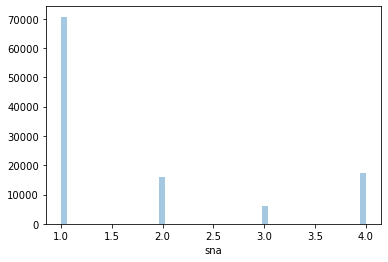

In [50]:
# Строим график распределения значений

sns.distplot(df['sna'], kde=False, rug=False)

**Вывод**

Преобладает категория 1 - почти 2/3 наблюдений.

#### first_time

In [51]:
# Смотрим распределение значений параметра first_time

df['first_time'].value_counts(normalize=True).round(2)

3    0.42
4    0.25
1    0.17
2    0.16
Name: first_time, dtype: float64

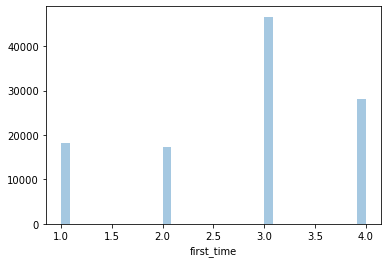

In [52]:
# Строим график распределения значений

sns.distplot(df['first_time'], kde=False, rug=False)

**Вывод**

Преобладают категории 3 и 4 (суммарно ок. 2/3 наблюдений), при этом кол-во записей с категориями 1 и 2 приблизительно одинаково.

#### foreign_passport

In [53]:
# Смотрим распределение значений параметра foreign_passport

df['foreign_passport'].value_counts(normalize=True).round(2)

N    0.85
Y    0.15
Name: foreign_passport, dtype: float64

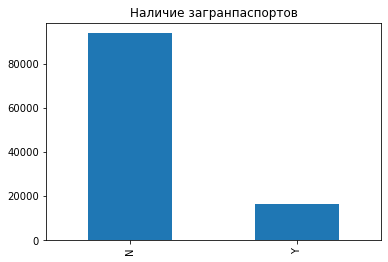

In [54]:
# Строим график распределения значений параметра foreign_passport

df['foreign_passport'].value_counts().plot(kind='bar', title='Наличие загранпаспортов')

In [55]:
# Кодируем значения переменной foreign_passport на целочисленные

df['foreign_passport'] = df['foreign_passport'].replace(yn_dict)

**Вывод**

У 85% заявителей отсутствует загранпаспорт.

Переменная перекодирована в целочисленный формат.

#### default

In [56]:
# Смотрим распределение признака default и убедимся в том, что пропуски только в тестовом датасете

df.groupby(by='Training')['default'].value_counts(normalize=True, dropna=False).round(2)

Training  default
0         NaN        1.00
1         0.0        0.87
          1.0        0.13
Name: default, dtype: float64

**Вывод**

В 13% случаев был неплатёж по кредиту.

---

### 4. Оценка корреляции

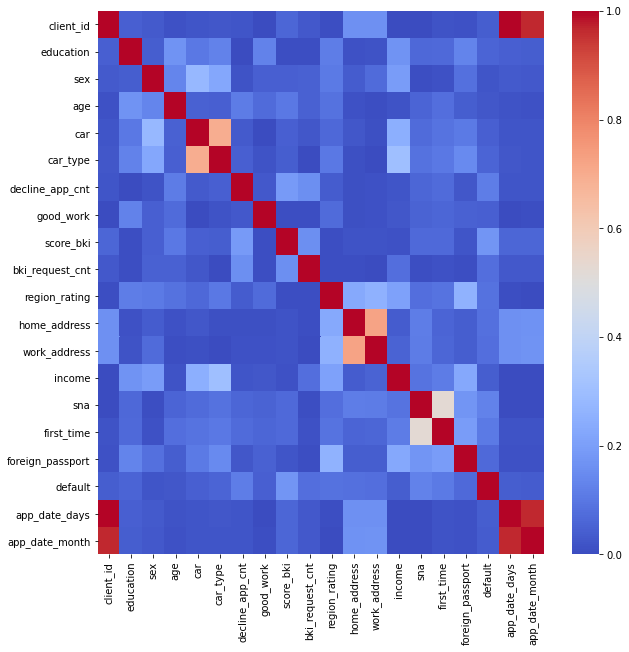

In [57]:
# Построим график корреляции для всех переменных

fig, ax = plt.subplots(figsize=(10,10))

c = df.drop(['Training'], axis=1).corr().abs()

sns.heatmap(c, vmin=0, vmax=1, annot=False, cmap='coolwarm', ax=ax)

In [58]:
# Смотрим список коэф. корреляции отдельных переменных на default

с = df.drop(['Training'], axis=1).corr()

c['default'].sort_values(ascending=False).drop('default').round(2)

score_bki           0.18
sna                 0.13
decline_app_cnt     0.11
first_time          0.11
region_rating       0.09
home_address        0.08
work_address        0.08
bki_request_cnt     0.08
foreign_passport    0.07
car_type            0.06
education           0.06
good_work           0.04
car                 0.04
income              0.04
app_date_days       0.04
client_id           0.04
app_date_month      0.04
age                 0.03
sex                 0.02
Name: default, dtype: float64

**Вывод**

Нет признаков с ярко выраженной положительной или отрицательной корреляцией с default - самая высокая корреляция обнаружена со скоринговым баллом из БКИ, что вполне естественно.

Среди корреляции между входными параметрами есть естественная мультиколлинеарность между app_date_days и app_date_month (оба параметра были выведены из app_date - даты подачи заявки). Также присутствует сильная связь между car / car_type и home_address / work_address, что было обнаружено и на этапе предварительного анализа переменных.

---

### 5. Подготовка данных к машинному обучению

#### Дополнительная обработка столбцов

In [59]:
# Уточняем типы оставшихся

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   client_id         110148 non-null  int64         
 1   app_date          110148 non-null  datetime64[ns]
 2   education         110148 non-null  int64         
 3   sex               110148 non-null  int64         
 4   age               110148 non-null  int64         
 5   car               110148 non-null  int64         
 6   car_type          110148 non-null  int64         
 7   decline_app_cnt   110148 non-null  int64         
 8   good_work         110148 non-null  int64         
 9   score_bki         110148 non-null  float64       
 10  bki_request_cnt   110148 non-null  int64         
 11  region_rating     110148 non-null  int64         
 12  home_address      110148 non-null  int64         
 13  work_address      110148 non-null  int64         
 14  inco

In [60]:
# двоичные переменные
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

# категориальные переменные
cat_cols = ['education', 'home_address', 'work_address', 'region_rating', 'sna', 'first_time', 'app_date_month']

# числовые переменные
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'score_bki', 'income', 'app_date_days']

In [61]:
# Распределение числовых переменных смещенно вправо, логарифмируем их, чтобы нормализировать их
# распределение. Добавление небольшой константы к np.log(x) исключает те ситуации, где np.log(0)

# for i in num_cols:
#     df[i] = np.log(df[i] + 1)
#     plt.figure()
#     sns.distplot(df[i][df[i] > 0].dropna(), kde=False, rug=False)
#     plt.title(i)
#     plt.show()

#### Визуализация числовых переменных с использованием boxplot

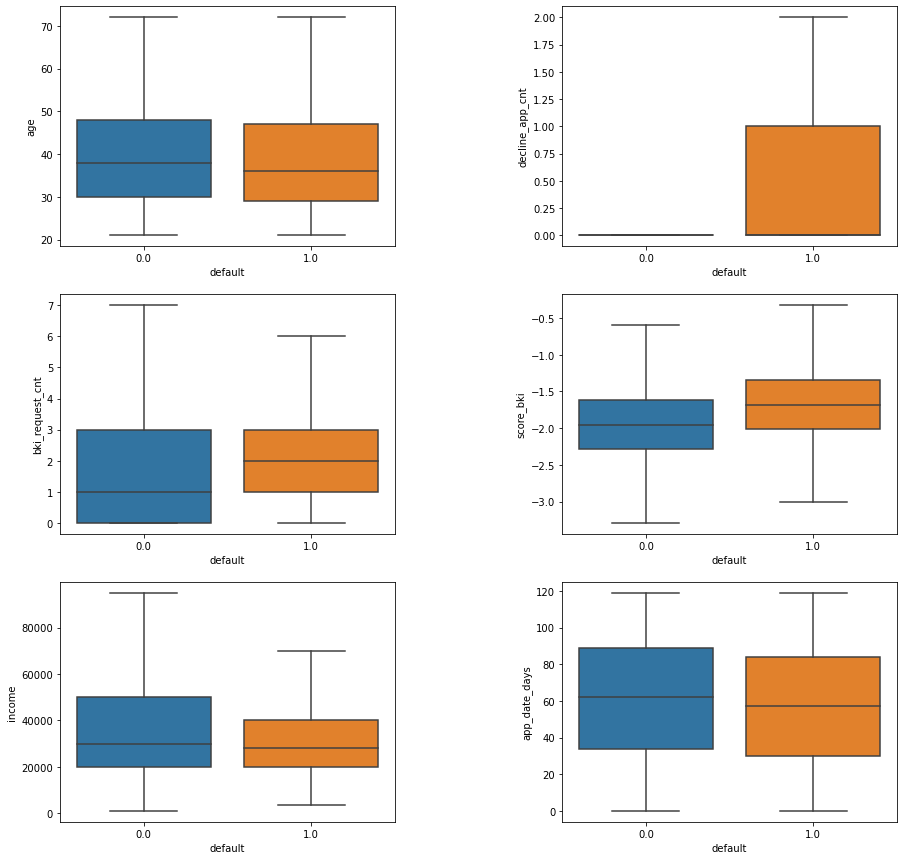

In [62]:
fig, axes = plt.subplots(ceil(len(num_cols) / 2), 2, figsize=(15,15))

plt.subplots_adjust(wspace = 0.5)

axes = axes.flatten()

for i in range(len(num_cols)):
    sns.boxplot(x="default", y=num_cols[i], data=df, orient = 'v', ax=axes[i], showfliers=False)

#### Преобразование категориальных признаков

<span style="color:red">**Важно!**</span>
При использовании LabelEncoder() необходимо убедиться, что признак не может принимать неизвестных ранее значений.
Поэтому их безопасно использовать на двоичных признаках, но на других нужно сначала убедиться, что у нас имеется полный перечень значений.

In [63]:
# Данный шаг излишен - мы уже преобразовали эти переменные в целочисленные

# # Для бинарных признаков используем LabelEncoder

# label_encoder = LabelEncoder()

# for column in bin_cols:
#     df[column] = label_encoder.fit_transform(df[column])
    
# # Убедимся в преобразовании

# df.head()

#### Оценка значимости числовых признаков

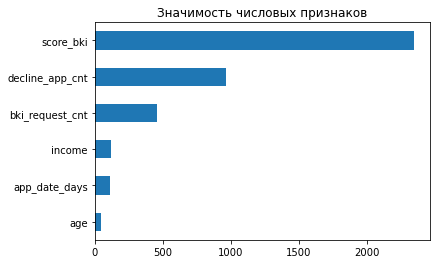

In [64]:
imp_num = pd.Series(f_classif(df[num_cols][df['Training'] == 1], df['default'][df['Training'] == 1])[0], index = num_cols)

imp_num.sort_values(inplace = True)

imp_num.plot(kind = 'barh', title='Значимость числовых признаков')

**Вывод**

Балл заёмщика БКИ является самым значимым признаком, за ним с большим отрывом идёт кол-во отказов.

Меньше всего на неплатёжеспособность влияет время подачи заявки и возраст.

#### Оценка значимости двоичных и категориальных признаков

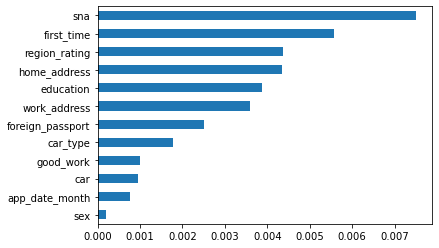

In [65]:
imp_cat = pd.Series(mutual_info_classif(df[bin_cols + cat_cols][df['Training'] == 1]
                                    ,df['default'][df['Training'] == 1]
                                    ,discrete_features=True)
                                    ,index=bin_cols + cat_cols)

imp_cat.sort_values(inplace = True)

imp_cat.plot(kind = 'barh')

**Вывод**

Наличие связи банка с заёмщиком и давность этой связи играют самую существенную роль.

#### Преобразование категориальных признаков в dummy-признаки

In [66]:
# Добавляем dummy-переменные для категориальных признаков

df = pd.get_dummies(df, columns=cat_cols, prefix=cat_cols)

In [67]:
# X_cat = OneHotEncoder(sparse=False).fit_transform(df[cat_cols].values)

# f'Кол-во колонок после преобразования: {np.shape(X_cat)[1]}'

#### Стандартизация числовых переменных

In [68]:
s = StandardScaler()

df[num_cols] = pd.DataFrame(s.fit_transform(df[num_cols]), columns=df[num_cols].columns)

In [69]:
# Убедимся в успешности преобразований

df.sample(5)

,client_id,app_date,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,income,foreign_passport,default,Training,app_date_days,education_0,education_1,education_2,education_3,education_4,home_address_1,home_address_2,home_address_3,work_address_1,work_address_2,work_address_3,region_rating_20,region_rating_30,region_rating_40,region_rating_50,region_rating_60,region_rating_70,region_rating_80,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4,app_date_month_1,app_date_month_2,app_date_month_3,app_date_month_4
80438,23891,2014-01-30,0,0.065167,0,0,-0.341893,0,0.269235,-0.443335,-0.242572,0,NaN,0,-0.996743,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0
101657,51712,2014-02-28,0,-0.629398,1,0,-0.341893,0,0.763501,-0.002207,-0.572972,0,NaN,0,-0.092638,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0
47992,85861,2014-04-02,1,-0.455757,0,0,-0.341893,0,1.714369,0.880049,-0.484865,0,0.0,1,0.936170,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
16850,97925,2014-04-15,1,1.454295,0,0,0.909522,0,2.021144,-0.443335,0.308095,0,0.0,1,1.341459,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
20092,74019,2014-03-21,1,0.238808,0,0,-0.341893,0,-0.696197,-0.443335,-0.440812,0,0.0,1,0.562058,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0


---

### 6. Построение модели и её оценка

#### Разделение данных для обучения

In [70]:
train_data = df.query('Training == 1').drop(['client_id', 'Training', 'app_date'], axis=1)
test_data = df.query('Training == 0').drop(['Training', 'app_date'], axis=1)

y = train_data['default'].values
X = train_data.drop(['default'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [71]:
# проверяем размерность

if (X.shape[0] == X_train.shape[0] + X_test.shape[0] and \
    X.shape[1] == X_train.shape[1] and X_train.shape[1] == X_test.shape[1] and \
    train_data.shape[1] == test_data.shape[1]):
    display('No errors')
else:
    display('Dimensions not matching!')
    
display(f'Размер тренировочного датасета: {train_data.shape}', \
        f'Размер проверочного датасета: {test_data.shape}')

'Dimensions not matching!'

'Размер тренировочного датасета: (73799, 42)'

'Размер проверочного датасета: (36349, 43)'

#### Обучаем модель

In [72]:
model = LogisticRegression(random_state=RANDOM_SEED, max_iter=1000)

model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

#### Оценка качества модели

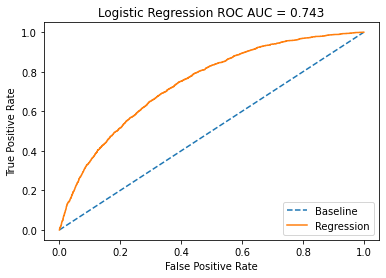

In [73]:
probs = model.predict_proba(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [74]:
# Печатаем метрики
preds = model.predict(X_test)
print('Accuracy: %.4f' % accuracy_score(y_test, preds))
print('Precision: %.4f' % precision_score(y_test, preds))
print('Recall: %.4f' % recall_score(y_test, preds))
print('F1: %.4f' % f1_score(y_test, preds))

Accuracy: 0.8742
Precision: 0.3585
Recall: 0.0208
F1: 0.0393


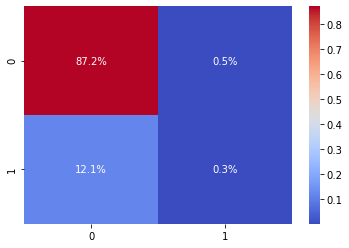

In [75]:
# Строим график значений предсказаний

cf_array = confusion_matrix(y_test, preds)

sns.heatmap(cf_array / np.sum(cf_array)
            ,annot=True
            ,fmt='.1%'
            ,cmap='coolwarm')

**Вывод**

* Accuracy - 87%
* Precision - 36%
* Recall - 2%
* F1 - 4%

На данном этапе модель практически не предсказывает неплатёжеспособных клиентов (ошибка 2 рода). 

---

### 7. Регуляризация и переобучение модели с новыми гиперпараметрами

In [76]:
# Запускаем GridSearch на небольшом кол-ве итераций max_iter=50 и с достаточно большой дельтой
# останова (tol = 1e-3), чтобы получить оптимальные параметры модели в первом приближении
# Код поиска позаимствован модели А. Соколова и А. Голобокова / слака

model = LogisticRegression(random_state=42)
iter_ = 50
epsilon_stop = 1e-3
param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_


# Печатаем параметры
best_parameters = model.get_params()

for param_name in sorted(best_parameters.keys()):
    print('\t%s: %r' % (param_name, best_parameters[param_name]))


# Печатаем метрики
preds = model.predict(X_test)
print('Accuracy: %.4f' % accuracy_score(y_test, preds))
print('Precision: %.4f' % precision_score(y_test, preds))
print('Recall: %.4f' % recall_score(y_test, preds))
print('F1: %.4f' % f1_score(y_test, preds))

	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'auto'
	n_jobs: None
	penalty: 'l2'
	random_state: 42
	solver: 'saga'
	tol: 0.001
	verbose: 0
	warm_start: False
Accuracy: 0.6724
Precision: 0.2262
Recall: 0.6804
F1: 0.3395


/home/akira/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


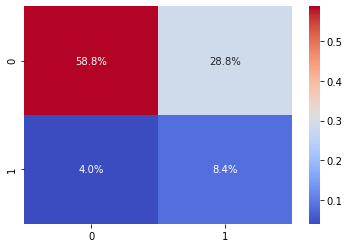

In [77]:
# Строим график значений предсказаний

cf_array = confusion_matrix(y_test, preds)

sns.heatmap(cf_array / np.sum(cf_array)
            ,annot=True
            ,fmt='.1%'
            ,cmap='coolwarm')

**Вывод**

* Accuracy - 67%
* Precision - 23%
* Recall - 68%
* F1 - 34%

Хоть оценка точности и упала по сравнению с первой пробой, существенно возросли полнота (recall) и F1.

#### Переобучаем модель с новыми параметрами

In [78]:
model = LogisticRegression(  random_state=RANDOM_SEED
                            ,C=1.0
                            ,class_weight='balanced'
                            ,dual=False
                            ,fit_intercept=True
                            ,intercept_scaling=1
                            ,l1_ratio=None
                            ,max_iter=1000
                            ,multi_class='auto'
                            ,n_jobs=None
                            ,penalty='none'
                            ,solver='newton-cg'
                            ,verbose=0
                            ,warm_start=False
)

model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, penalty='none',
                   random_state=42, solver='newton-cg')

#### Проверяем качество переобученной модели

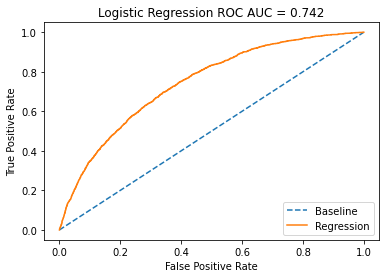

In [79]:
probs = model.predict_proba(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

---

### 8. Предсказания на проверочных данных

In [80]:
X_test = test_data.drop(['client_id', 'default'], axis=1)

y_pred_prob = model.predict_proba(X_test)[:,1]

In [81]:
submission = pd.DataFrame(test_data['client_id'])

submission['default'] = y_pred_prob
                           
submission.to_csv('submission.csv', index=False)

---

### 9. Итоги проекта

Получилось создать модель с целевым показателем **ROC AUC = 0.742** по б*о*льшей части в течение 2 дней хакатона (заготовки были, но многое пришлось доделывать / переделывать).

Не успел, но хотел ещё сделать рассчёт прибыльности, т.е. найти оптимальную границу предсказания дефолта, при которой достигается максимальная прибыль с учётом "промахов" модели.